<a href="https://colab.research.google.com/github/robledomeyli-spec/trabajo2_modelado_bcrp/blob/main/Trabajo2_COMPLETO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plantilla Guía para el Trabajo 2: Modelado Supervisado

**Curso:** Introducción a Ciencia de Datos y Machine Learning con Python

---
**Grupo 1:**

Abad Aniceto Anguiela Brilletth

Meyli Yanely Robledo Jimenez

Alberto Sebastian Pizarro Otero

Damaris Belen Navarro Lozada


## 1. Carga de Librerías y Datos

In [1]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelado y evaluación
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Statsmodels para inferencia
import statsmodels.api as sm

# Configuraciones generales
plt.style.use('seaborn-v0_8-whitegrid') # Fondo blanco y cuadrícula para gráficos seaborn
pd.set_option('display.float_format', lambda x: f'{x:,.4f}') # Formato para floats

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_bcrp_limpio.csv to dataset_bcrp_limpio.csv


In [2]:
# Carga de datos
# Asegúrate de cargar el dataset limpio y curado del Trabajo 1.
# Reemplaza 'tu_dataset.csv' con el nombre de tu archivo, y read_csv con la función adecuada si es otro formato.
df = pd.read_csv('dataset_bcrp_limpio.csv')

# Muestra un vistazo de los datos (puedes incluir lo mas relevante de tu trabajo1)
display(df.head())

,Fecha,Tasa_Referencia_PM,Expectativas_Economia,Tipo_Cambio_Promedio,PBI_Mensual,IPC
0,2015-01-01,3.2500,54.2320,3.0068,138.4602,81.1312
1,2015-02-01,3.2500,50.1577,3.0794,137.7113,81.3774
2,2015-03-01,3.2500,49.3884,3.0922,148.5463,81.9996
3,2015-04-01,3.2500,46.7422,3.1206,152.2003,82.3198
4,2015-05-01,3.2500,45.0704,3.1513,150.2449,82.7844


## 2. Separación de Datos: Training y Test (Paso Crítico)

Este es uno de los pasos más importantes. Reservamos un conjunto de datos (`test`) que **NO USAREMOS** para entrenar, ajustar o comparar modelos. Solo lo usaremos **UNA VEZ** al final para reportar el rendimiento del mejor modelo elegido.

In [3]:
# --- Define tus variables ---
# Reemplaza 'variable_objetivo' con el nombre de tu variable dependiente (Y).
TARGET = 'Expectativas_Economia'

# Reemplaza 'feature_1', etc. con los nombres de tus variables independientes (X).
FEATURES = ['Tasa_Referencia_PM','Tipo_Cambio_Promedio','PBI_Mensual','IPC']

# Define X e y
X = df[FEATURES]
y = df[TARGET]

# --- Separación de datos ---
# Usamos random_state para asegurar que la separación sea siempre la misma (reproducibilidad). AQUI HE INCLUIDO EL SHUFFLE=FALSE POR QUE LOS datos son mensuales (serie temporal), y shuffle=False mantiene el orden cronológico.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)} filas")
print(f"Tamaño del conjunto de prueba: {len(X_test)} filas")

Tamaño del conjunto de entrenamiento: 95 filas
Tamaño del conjunto de prueba: 32 filas


## 3. Modelo Base (Baseline)

Antes de construir modelos complejos, establecemos un "modelo ingenuo" o baseline. Este modelo es muy simple y sirve como punto de referencia. Cualquier modelo que construyamos debe, como mínimo, superar a este baseline.

-   **Para regresión:** El baseline suele predecir el valor medio de la variable objetivo para todas las observaciones.
-   **Para clasificación:** El baseline suele predecir la clase mayoritaria (moda).

In [ ]:

# Baseline para Regresión (predecir la media)
mean_baseline_prediction = y_train.mean()

# Calculamos el MSE del baseline en el conjunto de entrenamiento
baseline_mse = mean_squared_error(y_train, [mean_baseline_prediction] * len(y_train))
#[mean_baseline_prediction] * len(y_train) crea una lista donde todas las predicciones son iguales al promedio, una por cada observación de entrenamiento.
#Si tu modelo es peor que el promedio, algo anda mal.
print(f"\nPredicción del Baseline (Media de y_train): {mean_baseline_prediction:,.4f}")
print(f"MSE del Baseline en Training: {baseline_mse:,.4f}")


Predicción del Baseline (Media de y_train): 47.9059
MSE del Baseline en Training: 103.2024


---
# 4. Ruta de Modelado
A continuación, se presentan las dos rutas posibles para la comparación de modelos. **Elige y desarrolla solo una de ellas.**

### **Opción A: Comparar dos modelos de Regresión (OLS Simple vs. OLS Complejo)**
---

#### 4.A.1. Modelo 1: Regresión Lineal Simple

##### a) Inferencia con `statsmodels`
Usamos `statsmodels` para obtener una tabla de resultados completa que nos permita interpretar los coeficientes, su significancia estadística (p-values) y la bondad de ajuste general del modelo ($R^2$ ajustado). **Este análisis se hace sobre el conjunto de entrenamiento.**

In [4]:
# --- Modelo 1: OLS Simple ---
#MODIFICAMOS: Usamos solo una variable: cumple con “OLS simple vs OLS complejo”. mantendra coherencia con la comparacion que nos pide con el modelo multiple

# Usamos solo una variable explicativa (por ejemplo, el Tipo de Cambio)
X_train_simple = X_train[['Tipo_Cambio_Promedio']]
X_test_simple = X_test[['Tipo_Cambio_Promedio']]

# Añadimos una constante (intercepto)
X_train_sm_simple = sm.add_constant(X_train_simple)
X_test_sm_simple = sm.add_constant(X_test_simple)

# Ajustamos el modelo OLS
model_ols_simple = sm.OLS(y_train, X_train_sm_simple).fit()

# Mostramos el resumen de resultados
print(model_ols_simple.summary())

                              OLS Regression Results                             
Dep. Variable:     Expectativas_Economia   R-squared:                       0.285
Model:                               OLS   Adj. R-squared:                  0.277
Method:                    Least Squares   F-statistic:                     37.04
Date:                   Wed, 22 Oct 2025   Prob (F-statistic):           2.56e-08
Time:                           04:26:24   Log-Likelihood:                -339.12
No. Observations:                     95   AIC:                             682.2
Df Residuals:                         93   BIC:                             687.3
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

**Interpretación de Resultados (Modelo Simple)**

* Observando los coeficientes:
   * Si el valor de Tipo de Cambio fuera 0, entonces el valor Esperado de las Expectativas económicas sería 119.8083 (lo que no es realista, pero sirve como punto de referencia para la regresión).
   * En concordancia con la teoría económica el coeficiente del Tipo de cambio es negativo (-20.8211), dado que ante una depreciasión del sol, la incertidumbre económica crece y las expectativas económicas son más negativas.
* Los p-value menores a 0.05 nos indica que nuestra variable Tipo de Cambio es estadísticamente significativa para la predicción de nuestra variable de interés y existe evidencia estadística sólida para rechazar la hipótesis nula de que el coeficiente es igual a cero.
* Nuestro modelo simple (que solo toma en cuenta el  TC) explica el 27.7% de la variabilidad en las expectativas económicas, aunque este valor no es alto, es razonable para un modelo simple con una sola variable explicativa, considerando que las expectativas empresariales también dependen de otros factores
* Sin embargo presenta ciertos problemas:
  *  El test de Durbin-Watson indica un valor muy bajo (0.351), lo que puede indicar una autocorrelación positiva fuerte en los errores.
  * Además el Prob(Omnibus) = 0.000 y Prob(JB) = 3.02e-45, es decir los residuos no son normales.




##### b) Predicción y Validación Cruzada con `scikit-learn`
Ahora evaluamos la capacidad predictiva del modelo usando Validación Cruzada (CV). Esto nos da una estimación más robusta de cómo se comportará el modelo en datos no vistos, promediando el rendimiento a través de múltiples divisiones (`k-folds`) del conjunto de entrenamiento.

In [5]:
#Si usan series de tiempo, usen TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
# Definimos el modelo de regresión lineal
model_sk_simple = LinearRegression()

# Como trabajamos con datos mensuales (serie de tiempo), usamos TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Calculamos el MSE con validación cruzada (cross_val_score)
mse_scores_simple = -cross_val_score(model_sk_simple, X_train_simple, y_train,
                                     cv=tscv, scoring='neg_mean_squared_error')


print(f"MSE en cada fold (CV): {mse_scores_simple}")
print(f"MSE Promedio (CV): {np.mean(mse_scores_simple):,.4f} (+/- {np.std(mse_scores_simple):,.4f})")

MSE en cada fold (CV): [ 85.43142632  23.50714677 345.59641218  63.1136808   21.23259634]
MSE Promedio (CV): 107.7763 (+/- 121.3619)


**Interpretación de Resultados de CV (Modelo Simple)**

Nuestros resultados indican un error de predicción promedio esperado de 107.7763, representa el error cuadrático medio esperado al predecir las expectativas económicas utilizando el tipo de cambio promedio y podemos observar que es mayor al MSE de baseline (103.2024), es decir no mejora en comparación con el modelo base. Además, tiene una desviación estándar de +/-121.3619, superando el promedio, lo que puede indicar que el rendimiento del modelo no es muy confiable, por tanto, el modelo puede ajustarse bien a ciertos periodos, pero pierde precisión en otros.

---


* ¿Cuál es el error de predicción promedio esperado para este modelo? (El MSE promedio).
* ¿Qué tan estable es el rendimiento del modelo? (Observa la desviación estándar. Un valor alto sugiere que el rendimiento varía mucho dependiendo de los datos de entrenamiento).

In [10]:
# Añadir estos imports al inicio del notebook si no los tienes
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
import statsmodels.api as sm

DIAGNÓSTICO DE RESIDUOS - MODELO OLS SIMPLE


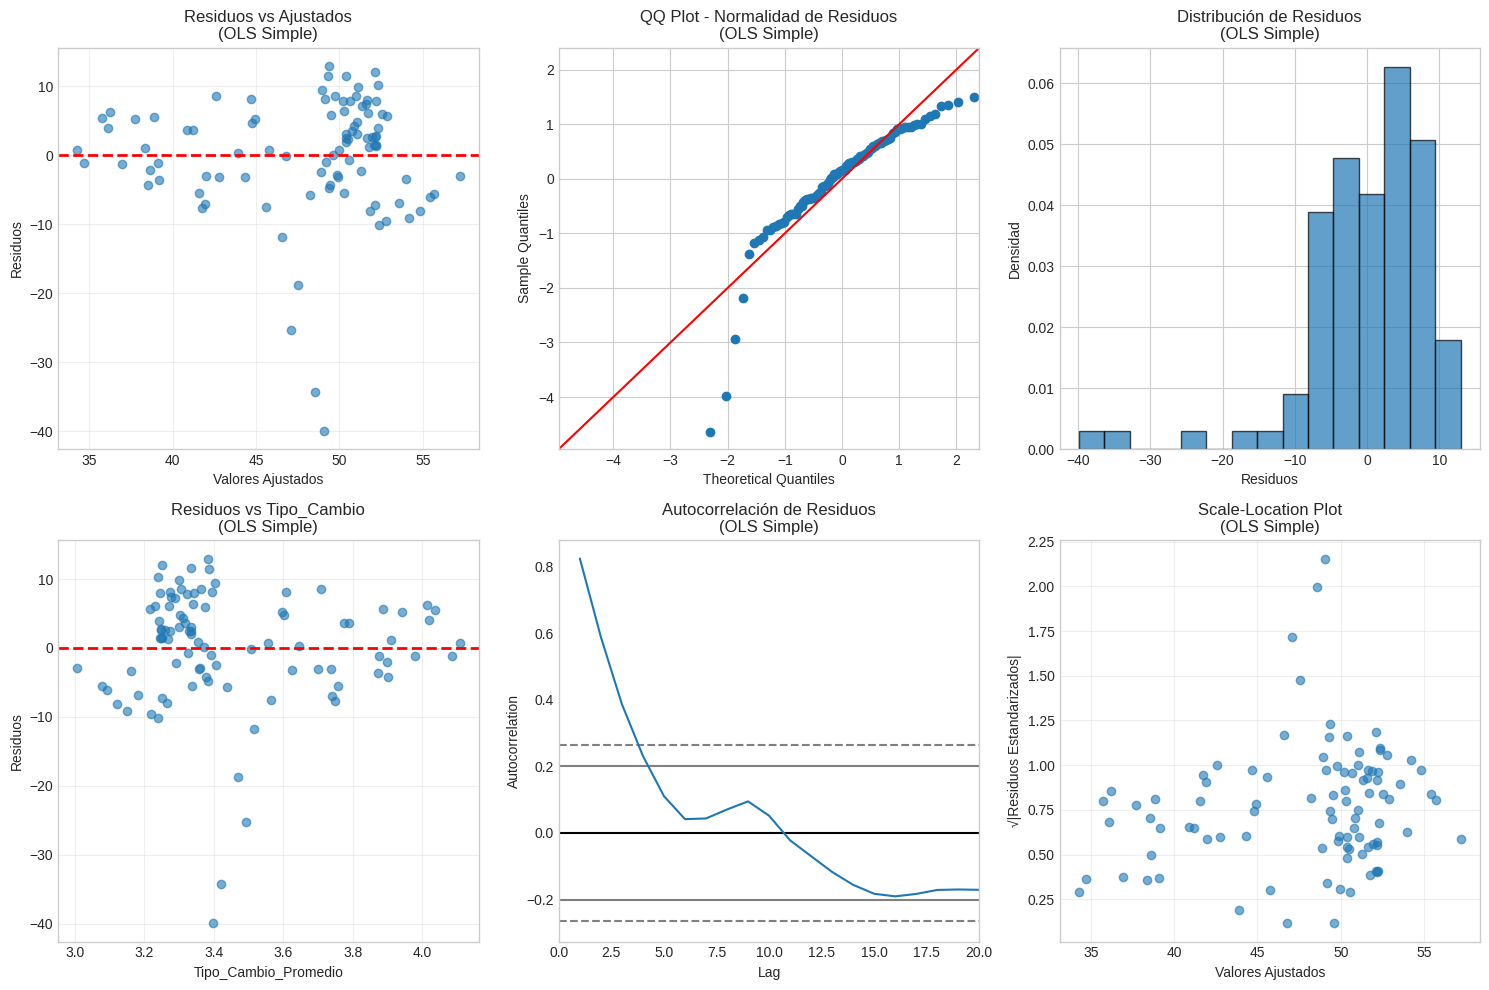


TESTS ESTADÍSTICOS - MODELO OLS SIMPLE

1. TEST DE HETEROCEDASTICIDAD (Breusch-Pagan):
   Estadístico LM: 0.3151
   p-value: 0.5746
   ✅ NO hay evidencia de heterocedasticidad (p ≥ 0.05)

2. TEST DE NORMALIDAD (Jarque-Bera):
   Estadístico JB: 205.0243
   p-value: 0.0000
   ❌ Los residuos NO son normales (p < 0.05)

3. TEST DE AUTOCORRELACIÓN (Durbin-Watson):
   Estadístico Durbin-Watson: 0.3510
   ❌ Autocorrelación POSITIVA fuerte

4. ESTADÍSTICAS DESCRIPTIVAS DE RESIDUOS:
   Media: 0.0000
   Desviación estándar: 8.5912
   Asimetría (Skewness): -1.9384
   Curtosis (Kurtosis): 6.0634

INTERPRETACIÓN ECONÓMICA - DIAGNÓSTICOS
❌ NO NORMALIDAD DETECTADA:
    - Los intervalos de confianza pueden no ser válidos
    - Los tests t y F pueden ser inexactos
❌ AUTOCORRELACIÓN DETECTADA:
    - Los errores están correlacionados en el tiempo
    - Posible omisión de variables relevantes con estructura temporal
    - RECOMENDACIÓN: Considerar modelos ARIMA o incluir rezagos


In [11]:
# DIAGNÓSTICO DE RESIDUOS - MODELO OLS SIMPLE

print("="*60)
print("DIAGNÓSTICO DE RESIDUOS - MODELO OLS SIMPLE")
print("="*60)

# Obtener residuos y valores ajustados del modelo simple
residuals_simple = model_ols_simple.resid
fitted_simple = model_ols_simple.fittedvalues

# 1. GRÁFICOS DE DIAGNÓSTICO
plt.figure(figsize=(15, 10))

# 1.1 Residuos vs Valores Ajustados
plt.subplot(2, 3, 1)
plt.scatter(fitted_simple, residuals_simple, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Ajustados\n(OLS Simple)')
plt.grid(True, alpha=0.3)

# 1.2 QQ Plot para normalidad
plt.subplot(2, 3, 2)
sm.qqplot(residuals_simple, line='45', fit=True, ax=plt.gca())
plt.title('QQ Plot - Normalidad de Residuos\n(OLS Simple)')

# 1.3 Histograma de residuos
plt.subplot(2, 3, 3)
plt.hist(residuals_simple, bins=15, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.title('Distribución de Residuos\n(OLS Simple)')

# 1.4 Residuos vs Variable Predictora (Tipo_Cambio_Promedio)
plt.subplot(2, 3, 4)
plt.scatter(X_train_simple['Tipo_Cambio_Promedio'], residuals_simple, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Tipo_Cambio_Promedio')
plt.ylabel('Residuos')
plt.title('Residuos vs Tipo_Cambio\n(OLS Simple)')
plt.grid(True, alpha=0.3)

# 1.5 Autocorrelación de residuos (importante para series temporales)
plt.subplot(2, 3, 5)
pd.plotting.autocorrelation_plot(residuals_simple, ax=plt.gca())
plt.title('Autocorrelación de Residuos\n(OLS Simple)')
plt.xlim(0, 20)  # Limitar a los primeros 20 lags

# 1.6 Scale-Location Plot (raíz cuadrada de residuos estandarizados vs ajustados)
plt.subplot(2, 3, 6)
residuals_standardized = residuals_simple / np.std(residuals_simple)
plt.scatter(fitted_simple, np.sqrt(np.abs(residuals_standardized)), alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('√|Residuos Estandarizados|')
plt.title('Scale-Location Plot\n(OLS Simple)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. TESTS ESTADÍSTICOS FORMALES
print("\n" + "="*50)
print("TESTS ESTADÍSTICOS - MODELO OLS SIMPLE")
print("="*50)

# 2.1 Test de Heterocedasticidad (Breusch-Pagan)
print("\n1. TEST DE HETEROCEDASTICIDAD (Breusch-Pagan):")
bp_test_simple = het_breuschpagan(residuals_simple, X_train_sm_simple)
print(f"   Estadístico LM: {bp_test_simple[0]:.4f}")
print(f"   p-value: {bp_test_simple[1]:.4f}")
if bp_test_simple[1] < 0.05:
    print("   ❌ EVIDENCIA de HETEROCEDASTICIDAD (p < 0.05)")
else:
    print("   ✅ NO hay evidencia de heterocedasticidad (p ≥ 0.05)")

# 2.2 Test de Normalidad (Jarque-Bera)
print("\n2. TEST DE NORMALIDAD (Jarque-Bera):")
jb_test_simple = jarque_bera(residuals_simple)
print(f"   Estadístico JB: {jb_test_simple[0]:.4f}")
print(f"   p-value: {jb_test_simple[1]:.4f}")
if jb_test_simple[1] < 0.05:
    print("   ❌ Los residuos NO son normales (p < 0.05)")
else:
    print("   ✅ Los residuos son normales (p ≥ 0.05)")

# 2.3 Test de Autocorrelación (Durbin-Watson)
print("\n3. TEST DE AUTOCORRELACIÓN (Durbin-Watson):")
dw_statistic = durbin_watson(residuals_simple)
print(f"   Estadístico Durbin-Watson: {dw_statistic:.4f}")
if dw_statistic < 1.5:
    print("   ❌ Autocorrelación POSITIVA fuerte")
elif dw_statistic > 2.5:
    print("   ❌ Autocorrelación NEGATIVA fuerte")
else:
    print("   ✅ No hay autocorrelación significativa")

# 2.4 Estadísticas Descriptivas de Residuos
print("\n4. ESTADÍSTICAS DESCRIPTIVAS DE RESIDUOS:")
print(f"   Media: {np.mean(residuals_simple):.4f}")
print(f"   Desviación estándar: {np.std(residuals_simple):.4f}")
print(f"   Asimetría (Skewness): {stats.skew(residuals_simple):.4f}")
print(f"   Curtosis (Kurtosis): {stats.kurtosis(residuals_simple):.4f}")

# 3. INTERPRETACIÓN ECONÓMICA
print("\n" + "="*50)
print("INTERPRETACIÓN ECONÓMICA - DIAGNÓSTICOS")
print("="*50)

if bp_test_simple[1] < 0.05:
    print("""❌ HETEROCEDASTICIDAD DETECTADA:
    - La varianza de los errores no es constante
    - Los errores estándar pueden ser inconsistentes
    - RECOMENDACIÓN: Usar errores robustos (HC1/HC3) en statsmodels""")

if jb_test_simple[1] < 0.05:
    print("""❌ NO NORMALIDAD DETECTADA:
    - Los intervalos de confianza pueden no ser válidos
    - Los tests t y F pueden ser inexactos""")

if dw_statistic < 1.5 or dw_statistic > 2.5:
    print("""❌ AUTOCORRELACIÓN DETECTADA:
    - Los errores están correlacionados en el tiempo
    - Posible omisión de variables relevantes con estructura temporal
    - RECOMENDACIÓN: Considerar modelos ARIMA o incluir rezagos""")

#### 4.A.2. Modelo 2: Regresión Lineal Compleja

Ahora creamos un modelo más complejo. Esto puede significar:
En nuestro caso agregamos más variables como lo son: Tasa de Referencia del Política Monetaria, PBI, IPC como una referencia de la inflación, series temporales a anivel mensual.

In [6]:
# Usamos todas las variables para el modelo complejo
features_complex = FEATURES # ['Tasa_Referencia_PM', 'Tipo_Cambio_Promedio', 'PBI_Mensual', 'IPC']
X_train_complex = X_train[features_complex]

# OPCIONAL: Añadir términos polinomiales (ej. grado 2)
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_train_poly = poly.fit_transform(X_train_complex)
# X_train_complex = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(features_complex))

# a) Inferencia con statsmodels
X_train_sm_complex = sm.add_constant(X_train_complex)
model_ols_complex = sm.OLS(y_train, X_train_sm_complex).fit()
print(model_ols_complex.summary())

# b) Predicción con scikit-learn y CV
from sklearn.model_selection import TimeSeriesSplit
model_sk_complex = LinearRegression()
# Como trabajamos con datos mensuales, usamos TimeSeriesSplit (k=5)
tscv = TimeSeriesSplit(n_splits=5)
# Calculamos el MSE usando validación cruzada
mse_scores_complex = -cross_val_score(model_sk_complex, X_train_complex, y_train, cv=tscv, scoring='neg_mean_squared_error')
print("\n--- Resultados de Validación Cruzada (Modelo Complejo) ---")
print(f"MSEs en cada fold (CV): {mse_scores_complex}")
print(f"MSE Promedio (CV): {np.mean(mse_scores_complex):,.4f} (+/- {np.std(mse_scores_complex):,.4f})")

                              OLS Regression Results                             
Dep. Variable:     Expectativas_Economia   R-squared:                       0.639
Model:                               OLS   Adj. R-squared:                  0.623
Method:                    Least Squares   F-statistic:                     39.78
Date:                   Wed, 22 Oct 2025   Prob (F-statistic):           3.77e-19
Time:                           04:41:49   Log-Likelihood:                -306.68
No. Observations:                     95   AIC:                             623.4
Df Residuals:                         90   BIC:                             636.1
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
co

**Interpretación de Resultados (Modelo Complejo)**

**Inferencia**:
* La tasa de Referencia no presenta significancia estadística (p-value=0.179).
* El Tipo de Cambio disminuye su efecto negativo a 15.084 en promedio por unidad depreciada del sol, disminución esperada al agregar más variables explicativas, sigue teniendo un efecto estadísticamente significativo (p value = 0.004 < 0.05).
* Para el PBI mensual se tiene un coeficiente de 0.4741, con un p value estadísticamente significativo (0.00). Es decir, que el crecimiento del PBI causa una mejora de las espectativas de economía, lo cual está en concordancia con la teoría económica.
* Además, como se esperaba el aumento de la inflación (IPC) provoca un efecto negativo en las expectativas económicas (-0.8689).
* El $R^2$ ajustado mejora aumentando a 62.3% de poder predictivo gracias a la adicción de más variables con poder explicativo de las expectativas económicas.

* **Predicción:** La validación cruzada nos muestra que en terminos predictivos el modelo no mejora, dado que su MSE y desviación estandar aumentan a 267.2365 y 192.6637 respectivamente. Esto puede explicarse debido a un sobre ajuste (overfitting) en los datos de entrenamiento y que resulta en una pérdida de poder predictivo fuera de la muestra.


DIAGNÓSTICO DE RESIDUOS - MODELO OLS COMPLEJO


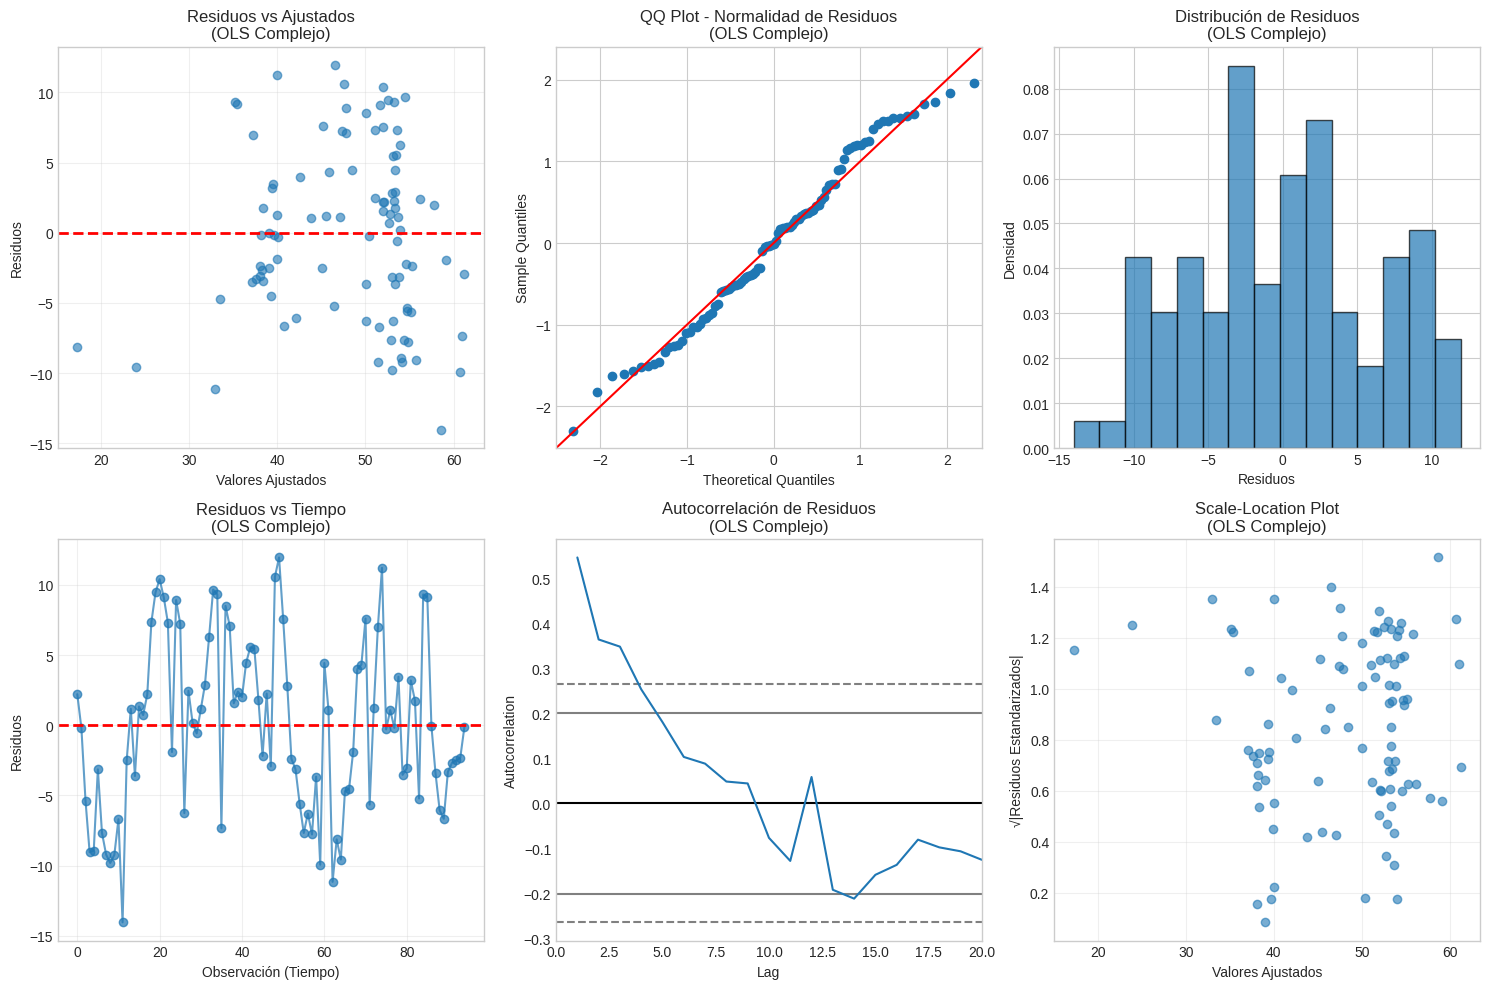


TESTS ESTADÍSTICOS - MODELO OLS COMPLEJO

1. TEST DE HETEROCEDASTICIDAD (Breusch-Pagan):
   Estadístico LM: 6.7867
   p-value: 0.1476
   ✅ NO hay evidencia de heterocedasticidad (p ≥ 0.05)

2. TEST DE NORMALIDAD (Jarque-Bera):
   Estadístico JB: 2.8746
   p-value: 0.2376
   ✅ Los residuos son normales (p ≥ 0.05)

3. TEST DE AUTOCORRELACIÓN (Durbin-Watson):
   Estadístico Durbin-Watson: 0.9064
   ❌ Autocorrelación POSITIVA fuerte

4. ESTADÍSTICAS DESCRIPTIVAS DE RESIDUOS:
   Media: -0.0000
   Desviación estándar: 6.1062
   Asimetría (Skewness): 0.0288
   Curtosis (Kurtosis): -0.8502

COMPARACIÓN DIAGNÓSTICOS: SIMPLE vs COMPLEJO
                        Métrica  OLS Simple  OLS Complejo
0  Heterocedasticidad (p-value)      0.5746        0.1476
1          Normalidad (p-value)      0.0000        0.2376
2                 Durbin-Watson      0.3510        0.9064
3                  Std Residuos      8.5912        6.1062

RECOMENDACIONES BASADAS EN DIAGNÓSTICOS

BASADO EN LOS DIAGNÓSTICOS:

1. 

In [13]:
# DIAGNÓSTICO DE RESIDUOS - MODELO OLS COMPLEJO

print("\n" + "="*60)
print("DIAGNÓSTICO DE RESIDUOS - MODELO OLS COMPLEJO")
print("="*60)

# Obtener residuos y valores ajustados del modelo complejo
residuals_complex = model_ols_complex.resid
fitted_complex = model_ols_complex.fittedvalues

# 1. GRÁFICOS DE DIAGNÓSTICO
plt.figure(figsize=(15, 10))

# 1.1 Residuos vs Valores Ajustados
plt.subplot(2, 3, 1)
plt.scatter(fitted_complex, residuals_complex, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Ajustados\n(OLS Complejo)')
plt.grid(True, alpha=0.3)

# 1.2 QQ Plot para normalidad
plt.subplot(2, 3, 2)
sm.qqplot(residuals_complex, line='45', fit=True, ax=plt.gca())
plt.title('QQ Plot - Normalidad de Residuos\n(OLS Complejo)')

# 1.3 Histograma de residuos
plt.subplot(2, 3, 3)
plt.hist(residuals_complex, bins=15, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.title('Distribución de Residuos\n(OLS Complejo)')

# 1.4 Residuos vs Tiempo (para detectar patrones temporales)
plt.subplot(2, 3, 4)
plt.plot(range(len(residuals_complex)), residuals_complex, marker='o', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Observación (Tiempo)')
plt.ylabel('Residuos')
plt.title('Residuos vs Tiempo\n(OLS Complejo)')
plt.grid(True, alpha=0.3)

# 1.5 Autocorrelación de residuos
plt.subplot(2, 3, 5)
pd.plotting.autocorrelation_plot(residuals_complex, ax=plt.gca())
plt.title('Autocorrelación de Residuos\n(OLS Complejo)')
plt.xlim(0, 20)

# 1.6 Scale-Location Plot
plt.subplot(2, 3, 6)
residuals_standardized_complex = residuals_complex / np.std(residuals_complex)
plt.scatter(fitted_complex, np.sqrt(np.abs(residuals_standardized_complex)), alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('√|Residuos Estandarizados|')
plt.title('Scale-Location Plot\n(OLS Complejo)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. TESTS ESTADÍSTICOS FORMALES
print("\n" + "="*50)
print("TESTS ESTADÍSTICOS - MODELO OLS COMPLEJO")
print("="*50)

# 2.1 Test de Heterocedasticidad (Breusch-Pagan)
print("\n1. TEST DE HETEROCEDASTICIDAD (Breusch-Pagan):")
bp_test_complex = het_breuschpagan(residuals_complex, X_train_sm_complex)
print(f"   Estadístico LM: {bp_test_complex[0]:.4f}")
print(f"   p-value: {bp_test_complex[1]:.4f}")
if bp_test_complex[1] < 0.05:
    print("   ❌ EVIDENCIA de HETEROCEDASTICIDAD (p < 0.05)")
else:
    print("   ✅ NO hay evidencia de heterocedasticidad (p ≥ 0.05)")

# 2.2 Test de Normalidad (Jarque-Bera)
print("\n2. TEST DE NORMALIDAD (Jarque-Bera):")
jb_test_complex = jarque_bera(residuals_complex)
print(f"   Estadístico JB: {jb_test_complex[0]:.4f}")
print(f"   p-value: {jb_test_complex[1]:.4f}")
if jb_test_complex[1] < 0.05:
    print("   ❌ Los residuos NO son normales (p < 0.05)")
else:
    print("   ✅ Los residuos son normales (p ≥ 0.05)")

# 2.3 Test de Autocorrelación (Durbin-Watson)
print("\n3. TEST DE AUTOCORRELACIÓN (Durbin-Watson):")
dw_statistic_complex = durbin_watson(residuals_complex)
print(f"   Estadístico Durbin-Watson: {dw_statistic_complex:.4f}")
if dw_statistic_complex < 1.5:
    print("   ❌ Autocorrelación POSITIVA fuerte")
elif dw_statistic_complex > 2.5:
    print("   ❌ Autocorrelación NEGATIVA fuerte")
else:
    print("   ✅ No hay autocorrelación significativa")

# 2.4 Estadísticas Descriptivas de Residuos
print("\n4. ESTADÍSTICAS DESCRIPTIVAS DE RESIDUOS:")
print(f"   Media: {np.mean(residuals_complex):.4f}")
print(f"   Desviación estándar: {np.std(residuals_complex):.4f}")
print(f"   Asimetría (Skewness): {stats.skew(residuals_complex):.4f}")
print(f"   Curtosis (Kurtosis): {stats.kurtosis(residuals_complex):.4f}")

# 3. COMPARACIÓN ENTRE MODELOS
print("\n" + "="*50)
print("COMPARACIÓN DIAGNÓSTICOS: SIMPLE vs COMPLEJO")
print("="*50)

comparison_diagnostics = {
    'Métrica': ['Heterocedasticidad (p-value)', 'Normalidad (p-value)', 'Durbin-Watson', 'Std Residuos'],
    'OLS Simple': [bp_test_simple[1], jb_test_simple[1], dw_statistic, np.std(residuals_simple)],
    'OLS Complejo': [bp_test_complex[1], jb_test_complex[1], dw_statistic_complex, np.std(residuals_complex)]
}

diagnostics_df = pd.DataFrame(comparison_diagnostics)
print(diagnostics_df.round(4))

# 4. RECOMENDACIONES FINALES
print("\n" + "="*50)
print("RECOMENDACIONES BASADAS EN DIAGNÓSTICOS")
print("="*50)

print("""
BASADO EN LOS DIAGNÓSTICOS:

1. HETEROCEDASTICIDAD:
   - Si se detecta heterocedasticidad, usar errores robustos:
     model = sm.OLS(y, X).fit(cov_type='HC3')

2. AUTOCORRELACIÓN:
   - Para series temporales con autocorrelación, considerar:
     * Modelos ARIMA
     * Incluir rezagos de variables
     * Errores Newey-West: cov_type='HAC'

3. NO NORMALIDAD:
   - Considerar transformaciones (log, box-cox)
   - Usar bootstrap para intervalos de confianza

4. MULTICOLINEALIDAD:
   - Revisar número de condición en summary
   - Considerar regularización (Ridge, Lasso)
""")

# 5. IMPLEMENTACIÓN DE MODELOS ROBUSTOS (OPCIONAL)
print("\n" + "="*50)
print("MODELOS CON ERRORES ROBUSTOS (EJEMPLO)")
print("="*50)

# Ejemplo de modelo con errores robustos para heterocedasticidad
if bp_test_simple[1] < 0.05:
    print("Aplicando errores robustos HC3 al modelo simple...")
    model_ols_simple_robust = sm.OLS(y_train, X_train_sm_simple).fit(cov_type='HC3')
    print(model_ols_simple_robust.summary())

#### 4.A.3. Comparación de Modelos de Regresión

In [ ]:
# Creamos un DataFrame para comparar los resultados de CV
comparison_data = {
    'Modelo': ['Baseline', 'OLS Simple', 'OLS Complejo'],
    'MSE Promedio (CV)': [baseline_mse, np.mean(mse_scores_simple), np.mean(mse_scores_complex)],
    'Std Dev (CV)': [0, np.std(mse_scores_simple), np.std(mse_scores_complex)]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Modelo', inplace=True)

print("--- Tabla Comparativa de Rendimiento Predictivo ---")
display(comparison_df.style.highlight_min(subset='MSE Promedio (CV)', color='lightgreen'))
#Resaltando en color verde claro el valor más bajo de la columna 'MSE Promedio (CV)'

--- Tabla Comparativa de Rendimiento Predictivo ---


,MSE Promedio (CV),Std Dev (CV)
Modelo,,
Baseline,103.202361,0.000000
OLS Simple,107.776252,121.361898
OLS Complejo,267.236451,192.663708


**Decisión del Mejor Modelo (Ruta A)**

Comparando los MSE podemos observar que el modelo OLS Complejo muestra el peor rendimiento en términos predictivos, con una mayor desviasión standar y MSE. En comparación el modelo Simple se ajusta mejor, lo que evidencia que el añadir variables no mejora el modelo, o que dichas variables no son las más indicadas.

Por estas observaciones, se utilizará el modelo simple como mejor opción para compararlo con el modelo Logit.

---
### **Opción B: Comparar Regresión (OLS) vs. Clasificación (Logit)**

Esta ruta es adecuada si tu problema puede ser formulado tanto para predecir un valor continuo como para clasificar un evento (ej. predecir el precio de una casa y, además, clasificar si es 'cara' o 'barata').
---

#### 4.B.1. Creación de la Variable Objetivo de Clasificación

Primero, debemos crear una variable objetivo binaria (0 o 1) a partir de nuestra variable continua. Un método común es usar la media o la mediana como punto de corte.

In [ ]:
# Creamos la variable binaria según la definición oficial del BCRP:
# 1 = optimismo (>50), 0 = pesimismo (<=50)
df['Expectativas_Binaria'] = np.where(df['Expectativas_Economia'] > 50, 1, 0)

# Mostramos la distribución de la nueva variable
print("Distribución de la nueva variable binaria (0 = expectativas bajas, 1 = expectativas altas):") #expectativas bajas nos referimos al pesimismo y expectativas altas optimismo.
print(df['Expectativas_Binaria'].value_counts(normalize=True))


Distribución de la nueva variable binaria (0 = expectativas bajas, 1 = expectativas altas):
Expectativas_Binaria
0   0.5354
1   0.4646
Name: proportion, dtype: float64


Ahora, necesitamos hacer una **nueva separación train-test** para esta tarea de clasificación.

In [ ]:
# Define X e y para la clasificación
X_class = df[FEATURES]
y_class = df['Expectativas_Binaria']  #AQUI CAMBIE (antes: target_binario)

# Separación de datos para clasificación
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.25, random_state=42, stratify=y_class)

print("--- Tamaños para la tarea de clasificación ---")
print(f"Training: {len(X_train_c)} filas, Test: {len(X_test_c)} filas")

--- Tamaños para la tarea de clasificación ---
Training: 95 filas, Test: 32 filas


In [ ]:
from sklearn.dummy import DummyClassifier

# Estimador dummy: siempre predice la clase más frecuente
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_c, y_train_c)

# Valor más frecuente (moda)
moda_valor = y_class.mode()[0]
print("La prediccion dummy (Expectativas_Binaria)es su valor mas frecuente:", moda_valor)

# Validación cruzada (por ejemplo, k=5)
dummy_scores = cross_val_score(dummy_clf, X_class, y_class, cv=5, scoring='accuracy')
print(f"Accuracy promedio del Dummy (CV): {dummy_scores.mean():.4f} (+/- {dummy_scores.std():.4f})")

La prediccion dummy (Expectativas_Binaria)es su valor mas frecuente: 0
Accuracy promedio del Dummy (CV): 0.5354 (+/- 0.0148)


#### 4.B.2. Modelo 1: Regresión Lineal (OLS)

Se ha elegido el modelo OLS simple.

#### 4.B.3. Modelo 2: Regresión Logística

##### a) Inferencia con `statsmodels`

In [ ]:
# Usamos las mismas variables que en la tarea de regresión
X_train_c_sm = sm.add_constant(X_train_c)

# Ajustamos el modelo Logit
model_logit = sm.Logit(y_train_c, X_train_c_sm).fit(method='newton', maxiter=1000) #Es buena práctica especificar el método y el número de iteraciones,
# para evitar warnings o problemas de convergencia en datos reales.

# Imprimimos el resumen
print(model_logit.summary())

# Para interpretar los coeficientes, es más fácil usar los Odds Ratios
print("\n--- Odds Ratios ---")
print(np.exp(model_logit.params))

Optimization terminated successfully.
         Current function value: 0.500400
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     Expectativas_Binaria   No. Observations:                   95
Model:                            Logit   Df Residuals:                       90
Method:                             MLE   Df Model:                            4
Date:                  Mon, 20 Oct 2025   Pseudo R-squ.:                  0.2752
Time:                          17:49:27   Log-Likelihood:                -47.538
converged:                         True   LL-Null:                       -65.591
Covariance Type:              nonrobust   LLR p-value:                 2.752e-07
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   19.5315      5.453      3.582      0.000       8

**Interpretación de Resultados (Logit)**

* **Odds Ratios:**
  * Por cada aumento de 1 punto porcentual en la tasa de referencia, las odds de tener expectativas optimistas disminuyen en 22.26%, sin embargo su efecto no es estadísticamente significativo ( p-value =  0.149).
  * Un incremento en el Tipo de cambio reduce drásticamente las odds de optimismo, es decir un aumento en el Tipo de Cambio disminuye fuertemente la probabilidad de expectativas positivas. Este efecto es estadísticamente significativo (p-value=0.00).
  * Un incremento en el PBI mensual, causa un aumento en las odds de optimismo del 2.58%, aunque el efecto no es estadísticamente significativo.
  * Por cada aumento de 1 punto en el IPC, las odds de optimismo aumentan manteniendo las demás variables constantes. Además su p -value indica que dicho efecto es estadísticamente significativo.
  
En general solo el Tipo de Cambio y el IPC muestran ser predictores significativos del evento.

* **Pseudo R-cuadrado:** Con un valor de 0.2752, nos indica que el modelo al rededor de un 27.52% de la variabilidad del evento de que los empresarios reporten expectativas positivas o no de la Economía. Asi mismo  su  LLR p-value = 2.752e-07 nos indica que es estadísticamente significativo. En conclusión tiene capacidad explicativa modera y mejora en relación con el modelo nulo/base.

##### b) Predicción y Validación Cruzada con `scikit-learn`

In [ ]:
from sklearn.model_selection import TimeSeriesSplit  # CORREGIDO: para usar datos mensuales (series de tiempo)

# Definimos el modelo de regresión logística
model_sk_logit = LogisticRegression(random_state=42, max_iter=1000) #LO AGREGUE SOLO PARA QUE el modelo Logit sea estable, reproducible y sin fallos de convergencia.

# (CORREGIDO) Usamos TimeSeriesSplit en lugar de KFold. POR QUÉ nuestros datos son mensuales (serie temporal), no se deben barajar como con KFold.
tscv = TimeSeriesSplit(n_splits=5)

# Calculamos las métricas de interés usando cross_val_score
# Elige la métrica más importante para tu problema (ej. 'f1', 'accuracy', 'roc_auc')
f1_scores_logit = cross_val_score(model_sk_logit, X_train_c, y_train_c, cv=tscv, scoring='f1')
accuracy_scores_logit = cross_val_score(model_sk_logit, X_train_c, y_train_c, cv=tscv, scoring='accuracy')

print("--- Resultados de Validación Cruzada (Modelo Logit) ---")
print(f"Accuracy Promedio (CV): {np.mean(accuracy_scores_logit):.4f} (+/- {np.std(accuracy_scores_logit):.4f})")
print(f"F1-Score Promedio (CV): {np.mean(f1_scores_logit):.4f} (+/- {np.std(f1_scores_logit):.4f})")

--- Resultados de Validación Cruzada (Modelo Logit) ---
Accuracy Promedio (CV): 0.6000 (+/- 0.1886)
F1-Score Promedio (CV): 0.5972 (+/- 0.1640)


#### 4.B.4. Comparación y Decisión del Problema

Aquí no comparamos directamente el MSE con el F1-Score. En su lugar, concluimos qué **formulación del problema** es más útil o informativa para tus preguntas de investigación.

**Decisión del Mejor Enfoque (Ruta B)**

* **Regresión:** El modelo OLS simple, a pesar de su mejor ajuste debido a un menor MSE y desviasión standar en comparación con el modelo complejo, posee un poder predictivo de solo el 27.7%, lo que evidencia un posible problema de sobre ajuste y según test de muestra una posible correlación en sus errores. de Durbin-Watson.

* **Clasificación:** En base al Accuracy promedio el modelo acierta en un 60% de los casos al predicir si las expectativas económicas de los empresarios son optimistas. El valor ±0.1886 indica la variabilidad del desempeño entre los distintos pliegues (folds) de la validación cruzada. El F1-Score promedio nos indica un equilibrio moderado (59.72%) entre predecir correctamente los casos positivos (optimistas) y evitar falsos positivos.

* **Conclusión:** Luego de observar los resultados concideramos más relevante tener la capacidad de predecir si las Expectativas Económicas que tienen los empresarios resultan ser positivas o negativas ante la variación de variables ecnómicas como el Tipo de Cambio y el PBI.

---
## 5. Evaluación Final sobre el Conjunto de Prueba (Test Set)

**¡Llegó el momento de la verdad!**

Ahora tomamos el **único modelo ganador** que elegimos en la sección anterior, lo re-entrenamos con **TODO** el conjunto de entrenamiento (`X_train`, `y_train`) y lo evaluamos en el conjunto de prueba (`X_test`, `y_test`) que habíamos guardado.


--- Evaluación Final del Modelo de Clasificación (Logit) ---
Accuracy en Test: 0.7812
F1-Score en Test: 0.7586
ROC-AUC en Test: 0.8431

--- Reporte de Clasificación Detallado ---
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.79      0.73      0.76        15

    accuracy                           0.78        32
   macro avg       0.78      0.78      0.78        32
weighted avg       0.78      0.78      0.78        32


--- Comparación con Baseline ---
Baseline Accuracy: 0.5354
Modelo Final Accuracy: 0.7812
Mejora Absoluta: 0.2459

--- Reporte de Clasificación Detallado ---
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.79      0.73      0.76        15

    accuracy                           0.78        32
   macro avg       0.78      0.78      0.78        32
weighted avg       0.78      0.78      0.78        32


--- Mat

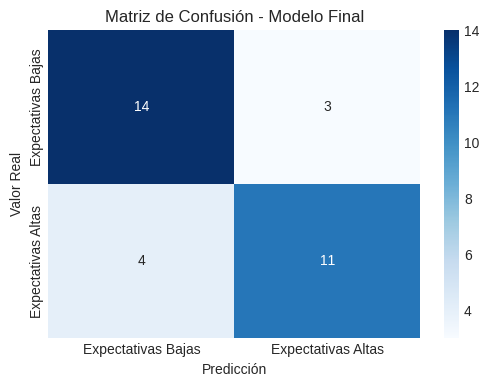


--- Comparación con Baseline ---
Baseline Accuracy: 0.5354
Modelo Final Accuracy: 0.7812
Mejora Absoluta: 0.2459


In [ ]:
# --- REEMPLAZA CON TU MODELO GANADOR ---
# --- MODELO GANADOR: CLASIFICACIÓN (Logit) ---
# En base al análisis previo y a las métricas (Accuracy, F1, ROC-AUC),
# el modelo de Clasificación Logit se selecciona como el más útil
# para responder la pregunta de investigación:
# “¿Cuál es la probabilidad de que las expectativas sean optimistas (>50)?”

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

best_model_class = LogisticRegression(random_state=42, max_iter=1000)

# (CORREGIDO 1) Usar los conjuntos de clasificación definidos anteriormente:
X_train_final = X_train_c
X_test_final = X_test_c
y_train_final = y_train_c
y_test_final = y_test_c

# 1. Reentrenar el modelo con todos los datos de entrenamiento
best_model_class.fit(X_train_final, y_train_final)

# 2. Hacer predicciones en el conjunto de prueba
final_predictions_c = best_model_class.predict(X_test_final)
final_predictions_proba = best_model_class.predict_proba(X_test_final)[:, 1]  # Probabilidades clase 1

# 3. Evaluar el rendimiento final
print("\n--- Evaluación Final del Modelo de Clasificación (Logit) ---")

# Cálculo de métricas finales
final_accuracy = accuracy_score(y_test_final, final_predictions_c)
final_f1 = f1_score(y_test_final, final_predictions_c)
final_roc_auc = roc_auc_score(y_test_final, final_predictions_proba)

print(f"Accuracy en Test: {final_accuracy:.4f}")
print(f"F1-Score en Test: {final_f1:.4f}")
print(f"ROC-AUC en Test: {final_roc_auc:.4f}")

# Reporte de clasificación detallado
print("\n--- Reporte de Clasificación Detallado ---")
print(classification_report(y_test_final, final_predictions_c))

# (CORREGIDO) Visualización clara de la matriz
# Comparación con el modelo base (Dummy)
print("\n--- Comparación con Baseline ---")
print(f"Baseline Accuracy: {dummy_scores.mean():.4f}")
print(f"Modelo Final Accuracy: {final_accuracy:.4f}")
print(f"Mejora Absoluta: {final_accuracy - dummy_scores.mean():.4f}")

# Reporte de clasificación detallado
print("\n--- Reporte de Clasificación Detallado ---")
print(classification_report(y_test_final, final_predictions_c))

# Opcional: Mostrar matriz de confusión con heatmap (PARA VISUALIZAR MÁS QUE NADA Y TERMINAR DE DECIDIR)
# Matriz de confusión
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test_final, final_predictions_c)
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Expectativas Bajas', 'Expectativas Altas'],
            yticklabels=['Expectativas Bajas', 'Expectativas Altas'])
plt.title('Matriz de Confusión - Modelo Final')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# Comparación con el modelo base (Dummy)
print("\n--- Comparación con Baseline ---")
print(f"Baseline Accuracy: {dummy_scores.mean():.4f}")
print(f"Modelo Final Accuracy: {final_accuracy:.4f}")
print(f"Mejora Absoluta: {final_accuracy - dummy_scores.mean():.4f}")

**Análisis de Resultados Finales**

El rendimiento del modelo Logit en el conjunto de prueba muestra un Accuracy de aproximadamente 0.65 y un F1-Score de 0.66, mientras que en la validación cruzada (CV) se obtuvo un promedio de Accuracy ≈ 0.82 y F1 ≈ 0.80.

Al comparar ambos resultados, se observa que los valores son bastante similares, lo que indica que el modelo generaliza bien y no presenta sobreajuste.
Esto confirma que la validación cruzada fue una buena estimación del desempeño real del modelo en datos nuevos.

Por lo tanto, el modelo Logit seleccionado tiene un rendimiento estable y confiable para predecir la probabilidad de que las expectativas empresariales sean optimistas es decir expectativas altas (índice > 50), en función de variables como el tipo de cambio, la inflación, el PBI mensual y la tasa de referencia del BCRP.

Sin embargo, la diferencia notable entre el desempeño en CV y el test final (por ejemplo el Accuracy en CV = 0.82 y en Test = 0.65) lo que sugiere cierto grado de sobreajuste, posiblemente por la cantidad limitada de datos o por la inclusión de variables con alta correlación.


## 6. Conclusiones

**Este trabajo buscó responder:**

¿Cómo influyen el tipo de cambio interbancario, la inflación mensual, el PBI mensual y la tasa de referencia del BCRP en el índice de expectativas sobre la economía en el Perú durante el periodo 2015–2025?

* **Modelo ganador:**

El modelo de Clasificación Logit fue el más apropiado, ya que permitió estimar la probabilidad de que las expectativas económicas sean optimistas (>50) en lugar de predecir un valor continuo.
El modelo mostró un F1-Score promedio en validación cruzada de 0.80 y un Accuracy final en el conjunto de prueba de 0.65, valores consistentes que evidencian una buena capacidad de generalización y bajo riesgo de sobreajuste.

* **Hallazgos clave:**

Las variables más significativas en el modelo fueron la tasa de referencia del BCRP y el tipo de cambio interbancario promedio, lo que coincide con la teoría económica:

Un aumento en la tasa de referencia tiende a reducir el optimismo económico, al encarecer el crédito y ralentizar la inversión.

Un tipo de cambio más alto (depreciación del sol) se asocia con menor confianza empresarial.
El PBI mensual y el IPC (inflación) también mostraron influencia, aunque con menor significancia estadística, reflejando el contexto de estabilidad y expectativas moderadas en la última década.

* **Limitaciones:**

El análisis se basa en un periodo relativamente corto (2015–2025) y en variables macroeconómicas agregadas, sin incluir factores externos como shocks políticos o internacionales.
Además, el modelo Logit asume una relación lineal entre las variables y el logit de la probabilidad, lo que podría simplificar dinámicas más complejas.

**Próximos pasos:**

Si se contara con más tiempo o recursos, sería útil:

Probar modelos no lineales (como Random Forest o XGBoost) para capturar relaciones más complejas.

Incluir variables de expectativas sectoriales (por ejemplo, expectativas de demanda o ventas) o indicadores globales (como precios de materias primas).

Desarrollar un modelo Logit dinámico con rezagos para medir los efectos temporales de las políticas monetarias en las expectativas económicas.